In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keplergl import KeplerGl
import sys
# isplay all columns
pd.set_option('display.max_columns', None)
sys.path.append('../utils/')
from functions import get_zone_info

C:\Users\mihai\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load data
cph = gpd.read_file('../data/processed/cop_area.shp')
car_trips = pd.read_csv('../data/processed/alltrips_before_trimming.csv')
# read the txt file "stops.txt" and create a pandas dataframe
stops = pd.read_csv('../data/processed/stops.txt', sep=',')

C:\Users\mihai\AppData\Local\Temp\ipykernel_36320\2760056887.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  car_trips = pd.read_csv('../data/processed/alltrips_before_trimming.csv')


In [3]:
# keep columns: stop_name, stop_lat, stop_lon
stops = stops[['stop_name', 'stop_lat', 'stop_lon']]
stops.head()

,stop_name,stop_lat,stop_lon
0,Dyrupgårds Alle (Odense Kommune),55.354918,10.345035
1,Vipperød St.,55.666828,11.738710
2,Holbæk St.,55.715750,11.708598
3,Hvalsø St.,55.595537,11.859821
4,Tølløse St.,55.611893,11.772803


In [4]:
# remove columns from car_trips : vehicleId, FromZoneID, ToZoneID, StartTimeUpdated
car_trips = car_trips.drop(columns=['vehicleId', 'FromZoneID', 'ToZoneID'])
car_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417354 entries, 0 to 417353
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   PersonID                 417354 non-null  float64
 1   LatitudeStart            417354 non-null  float64
 2   LongitudeStart           417354 non-null  float64
 3   LatitudeEnd              417354 non-null  float64
 4   LongitudeEnd             417354 non-null  float64
 5   StartTime                417354 non-null  object 
 6   EndTime                  417354 non-null  object 
 7   Age                      417354 non-null  float64
 8   Gender                   417354 non-null  object 
 9   KmDriven                 417354 non-null  float64
 10  TripDurationHours        417354 non-null  float64
 11  TripDurationMinutes      417354 non-null  float64
 12  AvgSpeed                 417354 non-null  float64
 13  Month                    417354 non-null  object 
 14  Week

In [5]:
# sort cph by zonedescri and print head
cph = cph.sort_values(by='zonedescri')
cph.head()

,OBJECTID,komnr,zoneid,zonenavn,zonedescri,numadresse,Shape_Leng,Shape_Area,geometry
204,6622,165,165032,Albertslund syd S,Albertslund Kommune,719,2833.998761,3.999415e+05,"POLYGON ((710843.199 6173082.418, 710889.352 6..."
913,7366,165,165023,Albertslund syd Station,Albertslund Kommune,284,2864.936954,4.434655e+05,"POLYGON ((711293.725 6173197.729, 710985.236 6..."
914,7367,165,165022,Albertslund syd N,Albertslund Kommune,158,2870.324874,4.518948e+05,"POLYGON ((711081.763 6174210.545, 711103.730 6..."
30,6666,165,165012,Albertslund nord SØ,Albertslund Kommune,1334,4701.005062,1.003677e+06,"POLYGON ((712827.337 6175339.891, 712826.940 6..."
213,7427,165,165015,Albertslund nord NV,Albertslund Kommune,74,13819.909903,5.954921e+06,"POLYGON ((710581.520 6178346.360, 710627.110 6..."


In [6]:
aggregated_gdf = cph.dissolve(by='zonedescri', as_index=False)
aggregated_gdf.head()

,zonedescri,geometry,OBJECTID,komnr,zoneid,zonenavn,numadresse,Shape_Leng,Shape_Area
0,Albertslund Kommune,"POLYGON ((710599.140 6171955.530, 710597.460 6...",6622,165,165032,Albertslund syd S,719,2833.998761,3.999415e+05
1,Allerød Kommune,"POLYGON ((705703.640 6191011.130, 705699.320 6...",6440,201,201024,Allerød CV,540,3950.717975,7.883861e+05
2,Ballerup Kommune,"POLYGON ((711571.540 6178267.240, 711559.640 6...",7755,151,151091,Kildedal,49,8546.735381,2.456872e+06
3,Brøndby Kommune,"MULTIPOLYGON (((714938.550 6168297.450, 714919...",6592,153,153023,Brøndbyvester Midt,558,4045.871436,9.080656e+05
4,Dragør Kommune,"MULTIPOLYGON (((725453.220 6162606.340, 725459...",6569,155,155016,Dragør CS,664,3363.981955,6.992127e+05


In [7]:
def get_zone_info1(shpfile, longitudes, latitudes, condition='start'):
    """
    Retrieve zone information based on given points' longitude and latitude.

    Args:
        shpfile_path (str): Path to the shapefile.
        longitudes (iterable): Longitudes of the points.
        latitudes (iterable): Latitudes of the points.

    Returns:
        pandas.DataFrame: A DataFrame containing zone information for each point.
            - zoneID: 6-digit zone ID as in the shapefile.
            - zoneName: Name of the zone as in the shapefile.
            - clustername: Cluster name.
    """

    # convert to WGS84
    new_gdf = shpfile.to_crs("EPSG:4326")

    # Create GeoDataFrame from provided longitudes and latitudes
    points_df = pd.DataFrame({
        'Longitude': longitudes,
        'Latitude': latitudes,
    })
    points_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df.Longitude, points_df.Latitude), crs="EPSG:4326")

    # Perform spatial join
    joined_gdf = gpd.sjoin(points_gdf, new_gdf, how="left", predicate='intersects',)

    # Select relevant columns and rename them, zonenavn, zonedescri
    zone_info_df = joined_gdf[['zoneid', 'zonenavn', 'zonedescri']].copy()
    if condition == 'start':
        zone_info_df.columns = ['StartZoneId', 'StartZoneName', 'StartZoneDescri']
    else:
        zone_info_df.columns = ['EndZoneId', 'EndZoneName', 'EndZoneDescri']

    return zone_info_df

# Example usage:
# longitudes = [longitude1, longitude2, ...]
# latitudes = [latitude1, latitude2, ...]
# zone_info_df = get_zone_info(shpfile_path, longitudes, latitudes)

In [8]:
def get_zone_info_filtered(shpfile, df, station_col, longitude_col, latitude_col):
    """
    Filter a DataFrame based on whether points fall within zones defined in a shapefile,
    and add zone information to those points.

    Args:
        shpfile (geopandas.GeoDataFrame): GeoDataFrame of the shapefile with zone shapes.
        df (pandas.DataFrame): DataFrame with points to check, including longitude and latitude.
        clustername_col (str): Column name in df for cluster names.
        longitude_col (str): Column name in df for longitudes.
        latitude_col (str): Column name in df for latitudes.

    Returns:
        pandas.DataFrame: Original DataFrame with added 'ZoneId' and 'ZoneName' where applicable.
    """
    
    # Convert shapefile and points to WGS84 if not already
    shpfile = shpfile.to_crs("EPSG:4326")
    station_col = df[station_col].name
    # Create GeoDataFrame from DataFrame's longitude and latitude
    points_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[longitude_col], df[latitude_col]), crs="EPSG:4326")

    # Perform spatial join to find which points fall within which zones
    joined_gdf = gpd.sjoin(points_gdf, shpfile, how="left", predicate='intersects')
    
    # Rename columns for zone ID and name from shapefile, assuming they are named 'zoneid' and 'zonenavn' in shpfile
    joined_gdf = joined_gdf[['zoneid', 'zonenavn', station_col, latitude_col, longitude_col,]]
    #joined_gdf.rename(columns={'zoneid': 'ZoneId', 'zonenavn': 'ZoneName'}, inplace=True)

    
    # Add cluster name column from specified clustername_col, if not already present
    return joined_gdf

In [9]:
filtered_stops = get_zone_info_filtered(cph, stops, 'stop_name', 'stop_lon', 'stop_lat')
# drop nan values
filtered_stops = filtered_stops.dropna()
filtered_stops.head()

,zoneid,zonenavn,stop_name,stop_lat,stop_lon
3,350033.0,Nørre Hvalsø,Hvalsø St.,55.595537,11.859821
5,250033.0,Frederikssund CS,Frederikssund St.,55.835809,12.065636
6,350021.0,Lejre,Lejre St.,55.604804,11.971702
7,240063.0,Ølstykke SØ,Ølstykke St.,55.795641,12.159712
9,259057.0,Køge Nord SV,Ølby St.,55.479751,12.175762


In [10]:
# fix invalid geometries in geometry column
cph['geometry'] = cph.geometry.buffer(0)

In [11]:
car_trips.columns

Index(['PersonID', 'LatitudeStart', 'LongitudeStart', 'LatitudeEnd',
       'LongitudeEnd', 'StartTime', 'EndTime', 'Age', 'Gender', 'KmDriven',
       'TripDurationHours', 'TripDurationMinutes', 'AvgSpeed', 'Month',
       'Weekday', 'StartHour', 'HaversineDistance', 'StartTimeUpdated',
       'TotalDurationMin', 'TripDistanceKm', 'TotalWalkingTimeMin',
       'TotalTransitTimeMin', 'Changes', 'PickupStationProximity',
       'DropoffStationProximity', 'CarDurationMin', 'CarDistanceKm', 'source'],
      dtype='object')

In [12]:
zoneinfo_dataframe = get_zone_info1(cph, car_trips['LongitudeEnd'].values, 
                                    car_trips['LatitudeEnd'].values, condition = 'end')

In [13]:
# print nr of nan values
zoneinfo_dataframe.isna().sum()

EndZoneId        183
EndZoneName      183
EndZoneDescri    183
dtype: int64

In [14]:
start_zoneinfo_dataframe = get_zone_info1(cph, car_trips['LongitudeStart'].values, car_trips['LatitudeStart'].values, condition = 'start')
start_zoneinfo_dataframe.isna().sum()

StartZoneId        198
StartZoneName      198
StartZoneDescri    198
dtype: int64

In [15]:
# append first 3 columns of zoneinfo_dataframe to dr_trips
car_trips = pd.concat([car_trips, start_zoneinfo_dataframe], axis=1)
car_trips = pd.concat([car_trips, zoneinfo_dataframe], axis=1)

In [16]:
# drop nan values
car_trips = car_trips.dropna()

In [17]:
common_values = np.intersect1d(car_trips['StartZoneDescri'].unique(), car_trips['EndZoneDescri'].unique())
common_values

# filter aggregated_gdf to only include the common values
aggregated_gdf = aggregated_gdf[aggregated_gdf['zonedescri'].isin(common_values)]

In [18]:
car_trips[car_trips['StartZoneName'] == car_trips['EndZoneName']].shape[0]

21810

In [19]:
# remove rows where CarDistanceKm <=1.0
car_trips = car_trips[car_trips['CarDistanceKm'] > 1.0]

In [20]:
# create new bool column RoundTrip where a trip is considered a round trip if StartZoneId == EndZoneId
car_trips['RoundTrip'] = car_trips['StartZoneName'] == car_trips['EndZoneName']


In [21]:
car_trips.columns

Index(['PersonID', 'LatitudeStart', 'LongitudeStart', 'LatitudeEnd',
       'LongitudeEnd', 'StartTime', 'EndTime', 'Age', 'Gender', 'KmDriven',
       'TripDurationHours', 'TripDurationMinutes', 'AvgSpeed', 'Month',
       'Weekday', 'StartHour', 'HaversineDistance', 'StartTimeUpdated',
       'TotalDurationMin', 'TripDistanceKm', 'TotalWalkingTimeMin',
       'TotalTransitTimeMin', 'Changes', 'PickupStationProximity',
       'DropoffStationProximity', 'CarDurationMin', 'CarDistanceKm', 'source',
       'StartZoneId', 'StartZoneName', 'StartZoneDescri', 'EndZoneId',
       'EndZoneName', 'EndZoneDescri', 'RoundTrip'],
      dtype='object')

In [22]:
car_trips.head()

,PersonID,LatitudeStart,LongitudeStart,LatitudeEnd,LongitudeEnd,StartTime,EndTime,Age,Gender,KmDriven,TripDurationHours,TripDurationMinutes,AvgSpeed,Month,Weekday,StartHour,HaversineDistance,StartTimeUpdated,TotalDurationMin,TripDistanceKm,TotalWalkingTimeMin,TotalTransitTimeMin,Changes,PickupStationProximity,DropoffStationProximity,CarDurationMin,CarDistanceKm,source,StartZoneId,StartZoneName,StartZoneDescri,EndZoneId,EndZoneName,EndZoneDescri,RoundTrip
5,137028.0,55.67683,12.57793,55.67534,12.58314,2017-08-08 10:32:32,2017-08-08 10:34:44,31.0,M,2.0,0.036667,2.200000,34.358803,August,Tuesday,10,0.366393,2023-12-26 10:32:32,6.716667,0.48025,6.716667,0.0,0.0,480.25,480.25,3.366667,1.27667,greenmobility,102111.0,Christiansborg,"Københavns Kommune, indre by og Christianshavn",102111.0,Christiansborg,"Københavns Kommune, indre by og Christianshavn",True
6,103996.0,55.67901,12.58150,55.67537,12.58327,2017-07-16 11:56:26,2017-07-16 12:03:38,21.0,M,1.0,0.120000,7.200000,4.666562,July,Sunday,11,0.419819,2023-12-24 11:56:26,7.883333,0.53582,7.883333,0.0,0.0,535.82,535.82,3.250000,1.13651,greenmobility,102121.0,Kgs. Nytorv,"Københavns Kommune, indre by og Christianshavn",102111.0,Christiansborg,"Københavns Kommune, indre by og Christianshavn",False
7,166029.0,55.68043,12.58109,55.67414,12.57805,2017-08-23 14:59:25,2017-08-23 15:28:24,21.0,M,1.0,0.483056,28.983333,1.159261,August,Wednesday,14,0.725149,2023-12-27 14:59:25,13.566667,0.96289,13.566667,0.0,0.0,962.89,962.89,4.266667,1.66995,greenmobility,102121.0,Kgs. Nytorv,"Københavns Kommune, indre by og Christianshavn",102111.0,Christiansborg,"Københavns Kommune, indre by og Christianshavn",False
9,120191.0,55.67655,12.57396,55.67485,12.58545,2017-07-28 16:09:37,2017-07-28 16:35:11,22.0,M,2.0,0.426111,25.566667,2.675911,July,Friday,16,0.745046,2023-12-22 16:09:37,13.233333,0.96496,13.233333,0.0,0.0,964.96,964.96,5.183333,1.44739,greenmobility,102131.0,Rådhuspladsen,"Københavns Kommune, indre by og Christianshavn",102111.0,Christiansborg,"Københavns Kommune, indre by og Christianshavn",False
10,228735.0,55.68212,12.56889,55.67538,12.58312,2017-09-21 15:40:32,2017-09-21 16:05:44,19.0,F,2.0,0.420000,25.200000,4.398087,September,Thursday,15,1.165535,2023-12-21 15:40:32,20.950000,1.48526,20.950000,0.0,0.0,1485.26,1485.26,7.050000,2.77694,greenmobility,102151.0,Nørreport,"Københavns Kommune, indre by og Christianshavn",102111.0,Christiansborg,"Københavns Kommune, indre by og Christianshavn",False


In [23]:
# for the round trips, print descriptive statistics for CarDistanceKm, KmDriven, TripDurationMinutes
car_trips[car_trips['RoundTrip'] == True][['CarDistanceKm', 'KmDriven', 'TripDurationMinutes']].describe()

,CarDistanceKm,KmDriven,TripDurationMinutes
count,1074.000000,1074.000000,1074.000000
mean,1.421951,6.740223,56.065239
std,0.476506,7.747803,117.409734
min,1.000310,2.000000,1.083333
25%,1.106045,2.000000,9.875000
50%,1.272280,3.000000,25.058333
75%,1.602100,8.000000,52.925000
max,8.384580,39.000000,1445.333333


In [24]:
# drop rows where RoundTrip == True
car_trips = car_trips[car_trips['RoundTrip'] == False]

In [25]:
car_trips[['CarDistanceKm', 'KmDriven', 'TripDurationMinutes']].describe()

,CarDistanceKm,KmDriven,TripDurationMinutes
count,382384.000000,382384.000000,382384.000000
mean,6.515783,7.636983,34.672356
std,4.645329,5.249064,264.449186
min,1.000120,1.000000,0.000000
25%,3.593305,4.000000,19.000000
50%,5.265720,6.000000,25.416667
75%,7.955705,9.000000,35.000000
max,44.303030,39.000000,132617.733333


In [26]:
# trim car_trips based on the 0.95th percentile of TripDurationMinutes
car_trips = car_trips[car_trips['TripDurationMinutes'] <= car_trips['TripDurationMinutes'].quantile(0.97)]
# drop rows with TripDurationMinutes <= 4 
car_trips = car_trips[car_trips['TripDurationMinutes'] >= 4]
# drop rows where KmDriven <2 
car_trips = car_trips[car_trips['KmDriven'] >= 2]
# drop AvgSpeed
car_trips = car_trips.drop(columns=['AvgSpeed'])
# create col AvgSpeed by dividing KmDriven by TripDurationHours
car_trips['AvgSpeed'] = car_trips['KmDriven'] / (car_trips['TripDurationHours'])
car_trips = car_trips[car_trips['AvgSpeed'] >= 5]
# create a column called TripDurationDiff where we subtract TripDurationMin from TotalDurationMin
car_trips['TripDurationDiff'] = car_trips['TotalDurationMin'] - car_trips['TripDurationMinutes']
# create a column called TripDurationDiffProcent where we subtract TripDurationMin from TotalDurationMin
# calculate the difference in %
car_trips['TripDurationDiffProcent'] = (car_trips['TripDurationDiff'] / car_trips['TripDurationMinutes']) * 100

# drop rows where TripDurationDiff <-40 and CarDistanceKm <= 2 





In [27]:
car_trips[["TotalDurationMin","TripDurationMinutes","TripDurationDiff", "TripDurationDiffProcent"]].head()

,TotalDurationMin,TripDurationMinutes,TripDurationDiff,TripDurationDiffProcent
11,24.433333,10.216667,14.216667,139.151713
12,11.616667,7.633333,3.983333,52.183406
13,12.833333,14.666667,-1.833333,-12.500000
14,17.300000,6.700000,10.600000,158.208955
16,11.950000,15.666667,-3.716667,-23.723404


In [28]:
car_trips['TripDurationDiffProcent'].describe()

count    363745.000000
mean         31.534281
std          58.547313
min         -95.625000
25%          -8.000000
50%          22.727273
75%          60.648148
max         870.714286
Name: TripDurationDiffProcent, dtype: float64

In [29]:
car_trips['CarsDiffTime'] = car_trips["CarDurationMin"] - car_trips["TripDurationMinutes"]

In [30]:
# drop rows where TripDurationDiff <-40 and CarDistanceKm <= 2 and KmDriven > 10
car_trips = car_trips[~((car_trips['TripDurationDiff'] < -40) & (car_trips['CarDistanceKm'] <= 2) & (car_trips['KmDriven'] >10))]

In [31]:
car_trips['CarsDiffTime'].describe()

count    362915.000000
mean        -14.730749
std          10.742529
min         -81.200000
25%         -19.400000
50%         -12.500000
75%          -7.333333
max          17.166667
Name: CarsDiffTime, dtype: float64

In [32]:
# drop rows where TripDurationDiff <-40 and CarDistanceKm <= 2 and KmDriven > 10
car_trips = car_trips[~((car_trips['CarsDiffTime'] < -50) & (car_trips['CarDistanceKm'] <= 2) & (car_trips['KmDriven'] >10))]

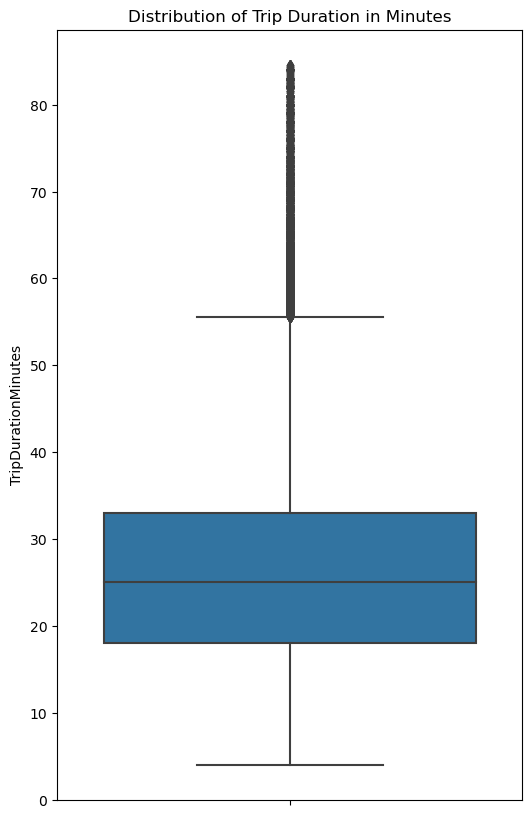

In [33]:
# plot TripDurationMinutes as boxplot using seaborn
plt.figure(figsize=(6, 10))
sns.boxplot(data=car_trips, y='TripDurationMinutes')
plt.title('Distribution of Trip Duration in Minutes')
plt.show()


In [34]:
len(car_trips)

362882

In [35]:
car_trips[['CarDistanceKm', 'KmDriven', 'TripDurationMinutes']].describe()

,CarDistanceKm,KmDriven,TripDurationMinutes
count,362882.000000,362882.000000,362882.000000
mean,6.600383,7.511555,27.020280
std,4.616634,4.875300,12.375305
min,1.000150,2.000000,4.000000
25%,3.690710,4.000000,18.000000
50%,5.345090,6.000000,25.000000
75%,8.032330,9.000000,33.000000
max,44.303030,39.000000,84.600000


In [36]:
# group by StartZoneId and count the number of trips
start_zone_counts = car_trips.groupby('StartZoneId').size().reset_index(name='StartZoneCounts')
# drop rows where StartZoneCounts <=5
start_zone_counts = start_zone_counts[start_zone_counts['StartZoneCounts'] > 5]
# merge with dr_trips on StartZoneId
car_trips = car_trips.merge(start_zone_counts, on='StartZoneId', how='left')
# rename startzoneid to zoneid
start_zone_counts = start_zone_counts.rename(columns={'StartZoneId': 'zoneid'})
# group by  EndZoneId and count the number of trips
end_zone_counts = car_trips.groupby('EndZoneId').size().reset_index(name='EndZoneCounts')
# drop rows where EndZoneCounts <=5
end_zone_counts = end_zone_counts[end_zone_counts['EndZoneCounts'] > 5]
# merge with dr_trips on EndZoneId
car_trips = car_trips.merge(end_zone_counts, on='EndZoneId', how='left')
# rename endzoneid to zoneid
end_zone_counts = end_zone_counts.rename(columns={'EndZoneId': 'zoneid'})

# group StartZoneName and get the mean of TripDurationDiff
start_zone_duration = car_trips.groupby('StartZoneName')['TripDurationDiff'].mean().reset_index(name='StartZoneTimeDiff')
# rename startzonename to zonenavn
start_zone_duration = start_zone_duration.rename(columns={'StartZoneName': 'zonenavn'})
# group EndZoneName and get the mean of TripDurationDiff
end_zone_duration = car_trips.groupby('EndZoneName')['TripDurationDiff'].mean().reset_index(name='EndZoneTimeDiff')
# rename endzonename to zonenavn
end_zone_duration = end_zone_duration.rename(columns={'EndZoneName': 'zonenavn'})

# Merge the DataFrames on 'zonenavn'
zone_time_diff = pd.merge(start_zone_duration, end_zone_duration, on='zonenavn', how='outer', suffixes=('_start', '_end'))
zone_time_diff.dropna(inplace=True)
zone_time_diff['StartEndDiff'] = zone_time_diff['StartZoneTimeDiff'] - zone_time_diff['EndZoneTimeDiff']

# group StartZoneName and get the mean of PickupStationProximity
start_zone_proximity = car_trips.groupby('StartZoneName')['PickupStationProximity'].mean().reset_index(name='StartZoneProximity')
# rename startzonename to zonenavn
start_zone_proximity = start_zone_proximity.rename(columns={'StartZoneName': 'zonenavn'})
# group EndZoneName and get the mean of DropoffStationProximity 
end_zone_proximity = car_trips.groupby('EndZoneName')['DropoffStationProximity'].mean().reset_index(name='EndZoneProximity')
# rename endzonename to zonenavn
end_zone_proximity = end_zone_proximity.rename(columns={'EndZoneName': 'zonenavn'})

# merge with cph
cph = cph.merge(start_zone_counts, on='zoneid', how='left')
cph = cph.merge(end_zone_counts, on='zoneid', how='left')
cph = cph.merge(start_zone_duration, on='zonenavn', how='left')
cph = cph.merge(end_zone_duration, on='zonenavn', how='left')
cph = cph.merge(zone_time_diff[['zonenavn', 'StartEndDiff']], on='zonenavn', how='left')
cph = cph.merge(start_zone_proximity, on='zonenavn', how='left')
cph = cph.merge(end_zone_proximity, on='zonenavn', how='left')
# in cph, create a column called 'TotalZoneCounts' which is the sum of StartZoneCounts and EndZoneCounts
cph['TotalZoneCounts'] = cph['StartZoneCounts'] + cph['EndZoneCounts']
# compute the weighted mean of StartZoneTimeDiff and EndZoneTimeDiff for each zone
cph['WMeanZoneTimeDiff'] = (cph['StartZoneTimeDiff'] * cph['StartZoneCounts'] + cph['EndZoneTimeDiff'] * cph['EndZoneCounts']) / cph['TotalZoneCounts']
# compute the weighted mean of StartZoneProximity and EndZoneProximity for each zone
cph['WMeanZoneProximity'] = (cph['StartZoneProximity'] * cph['StartZoneCounts'] + cph['EndZoneProximity'] * cph['EndZoneCounts']) / cph['TotalZoneCounts']

In [37]:
# drop nan values in car_trips
car_trips = car_trips.dropna()

In [38]:
common_values = np.intersect1d(car_trips['StartZoneId'].unique(), car_trips['EndZoneId'].unique())

In [39]:
# filter cph to only include the common values
cph = cph[cph['zoneid'].isin(common_values)]

In [40]:
# print zonenavn in cph where StartZoneTimeDiff the lowest 10
cph[['zonenavn', "WMeanZoneTimeDiff",'TotalZoneCounts']].sort_values(by='WMeanZoneTimeDiff', ascending=False).head(10)

,zonenavn,WMeanZoneTimeDiff,TotalZoneCounts
549,Avedøre Holme Ø,18.040857,525.0
315,Høje Gladsaxe SV,17.592667,300.0
840,DTU S,16.839141,12738.0
478,Herlev midt NØ,16.383152,3492.0
12,Albertslund syd NØ,16.375000,40.0
537,Hvidovre Hospital og Risbjerg Midt NØ,15.268416,2792.0
43,Ingeniørhøjskolen N,15.083384,1957.0
864,Kongens Lyngby N,14.821824,307.0
338,Glostrup syd N,14.606678,1223.0
52,Skovlunde N,14.383907,378.0


In [41]:
# count nan values in cph
cph.isna().sum()

OBJECTID              0
komnr                 0
zoneid                0
zonenavn              0
zonedescri            0
numadresse            0
Shape_Leng            0
Shape_Area            0
geometry              0
StartZoneCounts       0
EndZoneCounts         0
StartZoneTimeDiff     0
EndZoneTimeDiff       0
StartEndDiff          0
StartZoneProximity    0
EndZoneProximity      0
TotalZoneCounts       0
WMeanZoneTimeDiff     0
WMeanZoneProximity    0
dtype: int64

In [42]:
# save cph to shapefile with name cph_cars.shp
cph.to_file('../data/processed/cph_cars.shp')

C:\Users\mihai\AppData\Local\Temp\ipykernel_36320\1965844878.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cph.to_file('../data/processed/cph_cars.shp')


In [43]:
# print zonenavn in cph where StartZoneCounts the largest 10
cph[['zonenavn', 'StartZoneCounts']].sort_values(by='StartZoneCounts', ascending=True).head(10)

,zonenavn,StartZoneCounts
12,Albertslund syd NØ,19.0
493,Herlev syd NØ,19.0
924,Rødovre Nord NØ,26.0
306,Høje Gladsaxe SØ,26.0
301,Høje Gladsaxe NØ,31.0
302,Høje Gladsaxe S,32.0
480,Herlev syd Ø,34.0
324,Buddinge NØ,63.0
56,Ballerup N,77.0
634,Vanløse Nord NV,115.0


In [44]:
# print zonenavn in cph where EndZoneCounts the largest 10
cph[['zonenavn', 'EndZoneCounts']].sort_values(by='EndZoneCounts', ascending=True).head(10)

,zonenavn,EndZoneCounts
12,Albertslund syd NØ,21.0
493,Herlev syd NØ,22.0
306,Høje Gladsaxe SØ,24.0
924,Rødovre Nord NØ,28.0
301,Høje Gladsaxe NØ,29.0
480,Herlev syd Ø,30.0
302,Høje Gladsaxe S,32.0
966,Tårnby SV,51.0
324,Buddinge NØ,66.0
56,Ballerup N,96.0


In [45]:
car_trips[['TotalDurationMin','TripDurationMinutes']].describe()

,TotalDurationMin,TripDurationMinutes
count,362701.000000,362701.000000
mean,31.476755,27.013858
std,11.712129,12.369039
min,3.166667,4.000000
25%,23.066667,18.000000
50%,30.033333,25.000000
75%,38.616667,33.000000
max,149.066667,84.600000


In [46]:
car_trips.columns

Index(['PersonID', 'LatitudeStart', 'LongitudeStart', 'LatitudeEnd',
       'LongitudeEnd', 'StartTime', 'EndTime', 'Age', 'Gender', 'KmDriven',
       'TripDurationHours', 'TripDurationMinutes', 'Month', 'Weekday',
       'StartHour', 'HaversineDistance', 'StartTimeUpdated',
       'TotalDurationMin', 'TripDistanceKm', 'TotalWalkingTimeMin',
       'TotalTransitTimeMin', 'Changes', 'PickupStationProximity',
       'DropoffStationProximity', 'CarDurationMin', 'CarDistanceKm', 'source',
       'StartZoneId', 'StartZoneName', 'StartZoneDescri', 'EndZoneId',
       'EndZoneName', 'EndZoneDescri', 'RoundTrip', 'AvgSpeed',
       'TripDurationDiff', 'TripDurationDiffProcent', 'CarsDiffTime',
       'StartZoneCounts', 'EndZoneCounts'],
      dtype='object')

In [47]:
# count nan values in KmDriven
car_trips['TripDurationMinutes'].isna().sum()

0

In [48]:
# save car_trips to csv
car_trips.to_csv('../data/processed/car_trips_cleaned_zones.csv', index=False)

In [49]:
# drop StartZoneId and EndZoneId 
#car_trips = car_trips.drop(columns=['StartZoneId', 'EndZoneId'])

In [50]:
filtered_stops = filtered_stops[filtered_stops['zoneid'].isin(cph['zoneid'])]

In [51]:
# drop duplicates
filtered_stops.drop_duplicates(subset=['stop_name'], inplace=True)
# create new categorical column called station_type
# if stop_name contains 'Metro' then station_type is 'Metro'
# if stop name ends with 'St.' then station_type is 'S-Train'
# else station_type is 'Bus'
filtered_stops['station_type'] = np.where(filtered_stops['stop_name'].str.contains('Metro'), 'Metro', 
                                          np.where(filtered_stops['stop_name'].str.endswith('St.'), 'S-Train', 'Bus'))
# set station_type to categorical
filtered_stops['station_type'] = filtered_stops['station_type'].astype('category')

In [52]:
map = KeplerGl( height=700,)
#map.add_data(data=dr_trips, name='Donkey Republic Trips')
map.add_data(data=car_trips, name='Car Trips')
map.add_data(data=cph, name='Copenhagen Area')
map.add_data(filtered_stops, name='Public Transport Stops')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [53]:
map.save_to_html(file_name='kepler_map_car.html')

Map saved to kepler_map_car.html!
